In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
from pathlib import Path
from tqdm import tqdm
import random
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

# Установка seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Библиотеки загружены успешно!")
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Библиотеки загружены успешно!
PyTorch версия: 2.5.1+cu124
CUDA доступна: True
Используемое устройство: cuda


In [2]:
dataset_path = "flowers-recognition/flowers"

# Проверяем наличие датасета
if not os.path.exists(dataset_path):
    print(f"Датасет не найден в {dataset_path}")
    print("Пожалуйста, скачайте датасет с Kaggle или используйте команды выше")
else:
    print(f"Датасет найден в {dataset_path}")
    
    # Просмотр структуры датасета
    print("\nСтруктура датасета:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Показываем только первые 3 файла
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... и еще {len(files) - 3} файлов")


Датасет найден в flowers-recognition/flowers

Структура датасета:
flowers/
  tulip/
    13176521023_4d7cc74856_m.jpg
    16133917184_b5755756bd_n.jpg
    14055538059_b826e0ac2b_n.jpg
    ... и еще 981 файлов
  sunflower/
    4895721788_f10208ab77_n.jpg
    20777358950_c63ea569a1.jpg
    6140892289_92805cc590.jpg
    ... и еще 730 файлов
  dandelion/
    14362539701_cf19e588ca.jpg
    9472854850_fc9e1db673.jpg
    129019877_8eea2978ca_m.jpg
    ... и еще 1049 файлов
  rose/
    18464052396_6327841e65_n.jpg
    4900231976_f8ced2b42a_n.jpg
    3276552939_8c31b22d3e.jpg
    ... и еще 781 файлов
  daisy/
    9467543719_c4800becbb_m.jpg
    33923454163_9cabcaa733_n.jpg
    10993818044_4c19b86c82.jpg
    ... и еще 761 файлов


In [3]:
def analyze_dataset(dataset_path):
    """Анализ структуры и содержимого датасета"""
    
    # Получаем все пути к изображениям
    image_paths = []
    labels = []
    class_counts = defaultdict(int)
    
    # Поддерживаемые расширения изображений
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    
    for root, dirs, files in os.walk(dataset_path):
        class_name = os.path.basename(root)
        if class_name == os.path.basename(dataset_path):
            continue  # Пропускаем корневую папку
            
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                labels.append(class_name)
                class_counts[class_name] += 1
    
    print(f"Всего изображений: {len(image_paths)}")
    print(f"Количество классов: {len(class_counts)}")
    print("\nРаспределение по классам:")
    for class_name, count in sorted(class_counts.items()):
        print(f"  {class_name}: {count} изображений")
    
    return image_paths, labels, class_counts

# Анализируем датасет если он существует
if os.path.exists(dataset_path):
    image_paths, labels, class_counts = analyze_dataset(dataset_path)
    
    # Создание DataFrame для удобной работы
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    print(f"\nDataFrame создан: {df.shape}")
    print(df.head())
else:
    print("Сначала загрузите датасет!")


Всего изображений: 4317
Количество классов: 5

Распределение по классам:
  daisy: 764 изображений
  dandelion: 1052 изображений
  rose: 784 изображений
  sunflower: 733 изображений
  tulip: 984 изображений

DataFrame создан: (4317, 2)
                                          image_path  label
0  flowers-recognition/flowers/tulip/13176521023_...  tulip
1  flowers-recognition/flowers/tulip/16133917184_...  tulip
2  flowers-recognition/flowers/tulip/14055538059_...  tulip
3  flowers-recognition/flowers/tulip/2254152047_d...  tulip
4  flowers-recognition/flowers/tulip/7166598930_1...  tulip


Примеры изображений из датасета:


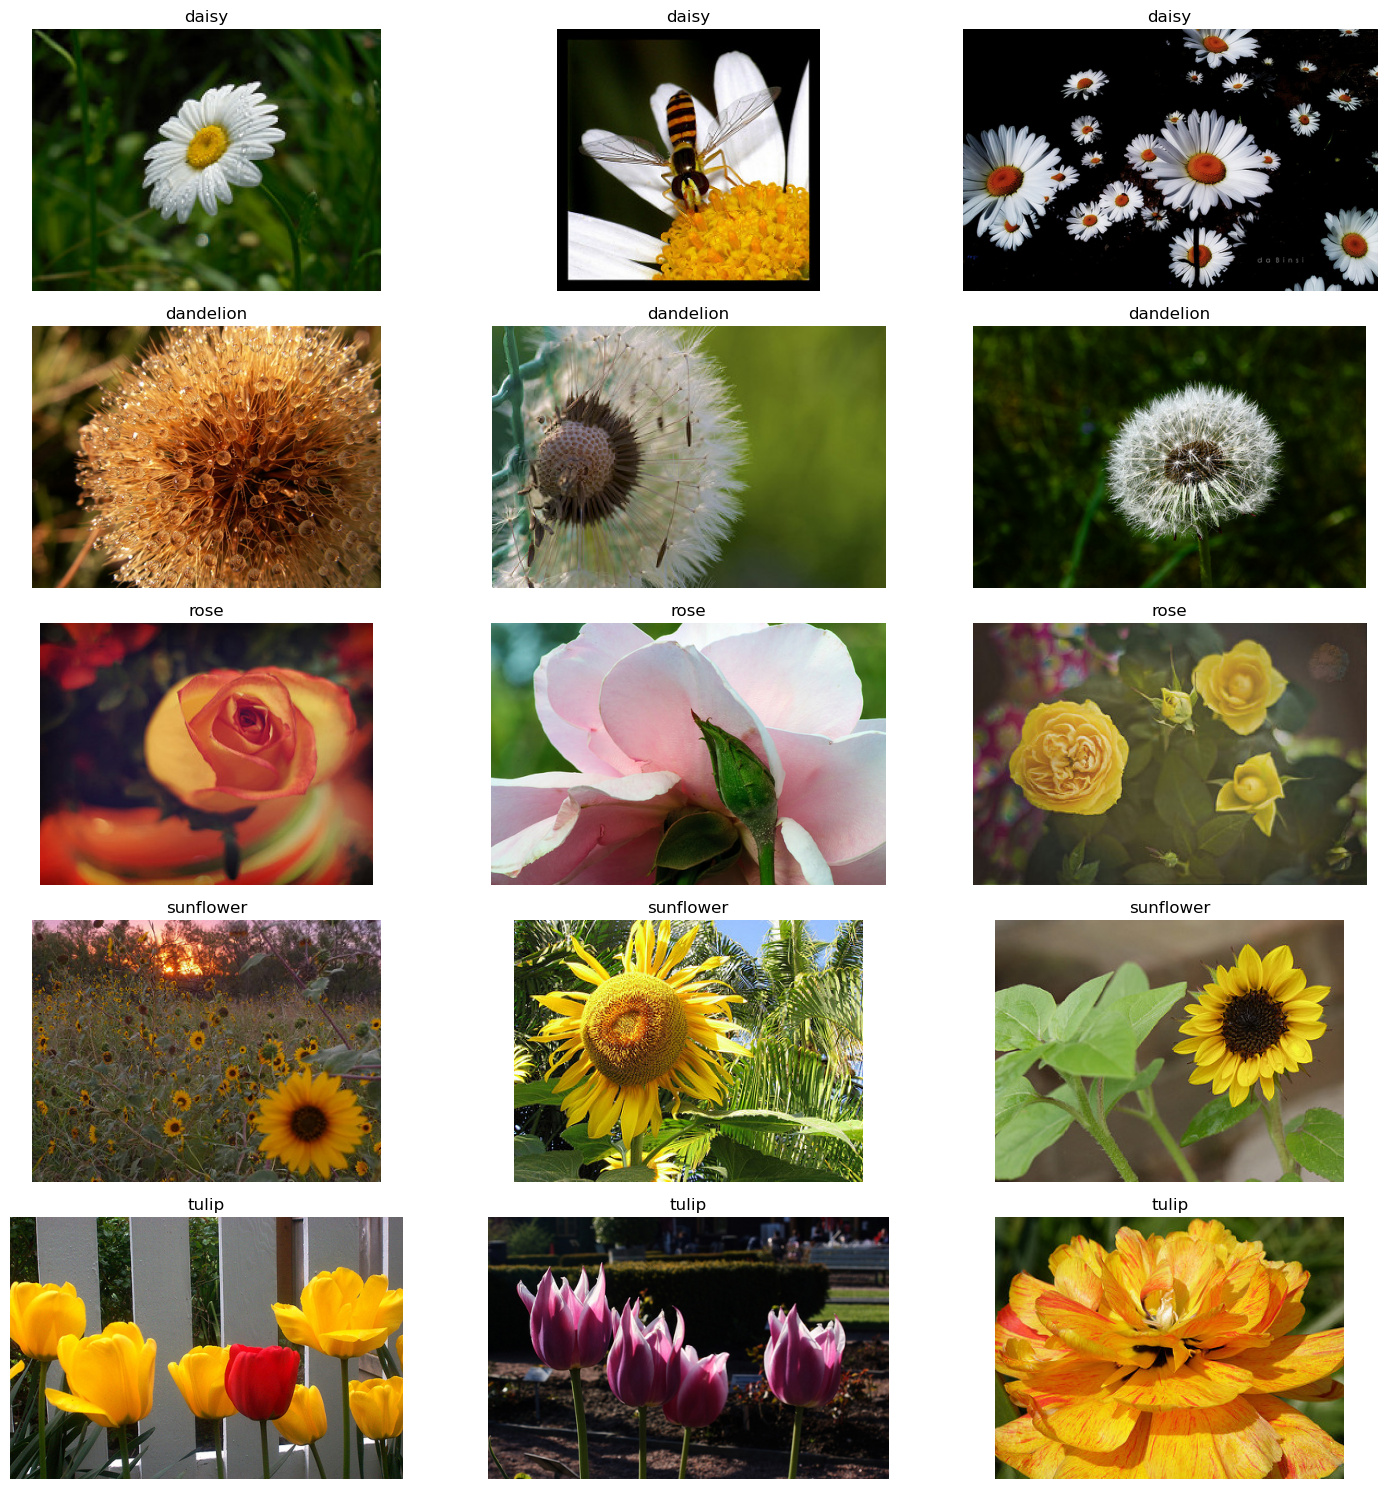

In [4]:
# Визуализация примеров изображений из каждого класса
def show_sample_images(df, n_samples=2):
    """Показать примеры изображений для каждого класса"""
    
    classes = df['label'].unique()
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(5*n_samples, 3*len(classes)))
    
    if len(classes) == 1:
        axes = [axes]
    
    for i, class_name in enumerate(sorted(classes)):
        class_images = df[df['label'] == class_name]['image_path'].tolist()
        sample_images = random.sample(class_images, min(n_samples, len(class_images)))
        
        for j, img_path in enumerate(sample_images):
            try:
                img = Image.open(img_path)
                if len(classes) > 1:
                    axes[i][j].imshow(img)
                    axes[i][j].set_title(f"{class_name}")
                    axes[i][j].axis('off')
                else:
                    axes[j].imshow(img)
                    axes[j].set_title(f"{class_name}")
                    axes[j].axis('off')
            except Exception as e:
                print(f"Ошибка загрузки {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# Показываем примеры если датасет доступен
if os.path.exists(dataset_path) and 'df' in locals():
    print("Примеры изображений из датасета:")
    show_sample_images(df, n_samples=3)


In [5]:
class FlowerDataset(Dataset):
    """Класс для работы с датасетом цветов"""
    
    def __init__(self, image_paths, labels, transform=None, label_to_idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Создаем маппинг лейблов в индексы
        if label_to_idx is None:
            unique_labels = sorted(list(set(labels)))
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        else:
            self.label_to_idx = label_to_idx
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Загрузка изображения
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Ошибка загрузки {image_path}: {e}")
            # Создаем черное изображение в случае ошибки
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        
        # Применяем трансформации
        if self.transform:
            image = self.transform(image)
        
        # Преобразуем лейбл в индекс
        label_idx = self.label_to_idx[label]
        
        return image, label_idx, image_path

# Определяем трансформации для обучения и валидации
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset класс и трансформации определены!")


Dataset класс и трансформации определены!


In [6]:
# Разделение датасета на train/validation/test
from sklearn.model_selection import train_test_split

if os.path.exists(dataset_path) and 'df' in locals():
    # Стратифицированное разделение для сохранения пропорций классов
    train_df, temp_df = train_test_split(
        df, test_size=0.3, random_state=42, stratify=df['label']
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
    )
    
    print(f"Размеры датасетов:")
    print(f"  Обучение: {len(train_df)} изображений")
    print(f"  Валидация: {len(val_df)} изображений") 
    print(f"  Тест: {len(test_df)} изображений")
    
    # Создаем datasets
    train_dataset = FlowerDataset(
        train_df['image_path'].tolist(),
        train_df['label'].tolist(),
        transform=train_transform
    )
    
    val_dataset = FlowerDataset(
        val_df['image_path'].tolist(),
        val_df['label'].tolist(),
        transform=val_transform,
        label_to_idx=train_dataset.label_to_idx
    )
    
    test_dataset = FlowerDataset(
        test_df['image_path'].tolist(),
        test_df['label'].tolist(),
        transform=val_transform,
        label_to_idx=train_dataset.label_to_idx
    )
    
    # Создаем DataLoaders
    batch_size = 32
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    
    print(f"\nDataLoaders созданы с batch_size={batch_size}")
    print(f"Количество классов: {len(train_dataset.label_to_idx)}")
    print(f"Классы: {list(train_dataset.label_to_idx.keys())}")
    
else:
    print("Датасет не найден!")


Размеры датасетов:
  Обучение: 3021 изображений
  Валидация: 648 изображений
  Тест: 648 изображений

DataLoaders созданы с batch_size=32
Количество классов: 5
Классы: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
class FlowerFeatureExtractor(nn.Module):
    """Модель для извлечения признаков изображений цветов"""
    
    def __init__(self, backbone='resnet50', num_classes=5, feature_dim=512):
        super(FlowerFeatureExtractor, self).__init__()
        
        self.backbone_name = backbone
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        
        # Загружаем предобученную модель
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            backbone_output_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Убираем последний слой
            
        elif backbone == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            backbone_output_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
            
        elif backbone == 'vgg16':
            self.backbone = models.vgg16(pretrained=True)
            backbone_output_dim = self.backbone.classifier[6].in_features
            self.backbone.classifier = nn.Sequential(*list(self.backbone.classifier.children())[:-1])
            
        else:
            raise ValueError(f"Неподдерживаемая архитектура: {backbone}")
        
        # Создаем слои для извлечения признаков и классификации
        self.feature_extractor = nn.Sequential(
            nn.Linear(backbone_output_dim, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(feature_dim)
        )
        
        # Классификационная головка
        self.classifier = nn.Linear(feature_dim, num_classes)
        
        # Инициализация весов
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Инициализация весов новых слоев"""
        for m in [self.feature_extractor, self.classifier]:
            for module in m.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x, return_features=False):
        """Прямой проход через модель"""
        # Извлекаем признаки из backbone
        backbone_features = self.backbone(x)
        
        # Получаем финальные признаки
        features = self.feature_extractor(backbone_features)
        
        if return_features:
            return features
        
        # Классификация
        logits = self.classifier(features)
        
        return logits, features
    
    def extract_features(self, x):
        """Извлечение нормализованных признаков для поиска похожих изображений"""
        with torch.no_grad():
            features = self.forward(x, return_features=True)
            # L2 нормализация для косинусного сходства
            features = nn.functional.normalize(features, p=2, dim=1)
        return features

print("Модель FlowerFeatureExtractor определена!")


Модель FlowerFeatureExtractor определена!


In [8]:
# Создаем модель и переносим на устройство
if 'train_dataset' in locals():
    num_classes = len(train_dataset.label_to_idx)
    model = FlowerFeatureExtractor(
        backbone='resnet50',
        num_classes=num_classes,
        feature_dim=512
    ).to(device)
    
    # Определяем loss функцию и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    print(f"Модель создана с {num_classes} классами")
    print(f"Общее количество параметров: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
else:
    print("Сначала загрузите и подготовьте датасет!")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/khizhniy/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:25<00:00, 4.07MB/s]


Модель создана с 5 классами
Общее количество параметров: 24,560,709
Обучаемых параметров: 24,560,709


In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Обучение модели на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for images, labels, _ in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        logits, features = model(images)
        loss = criterion(logits, labels)
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        
        # Статистика
        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Обновляем прогресс-бар
        progress_bar.set_postfix({
            'Loss': f'{running_loss/len(progress_bar):.4f}',
            'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            logits, features = model(images)
            loss = criterion(logits, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

print("Функции обучения и валидации определены!")


Функции обучения и валидации определены!


In [10]:
# Обучение модели
if 'model' in locals() and 'train_loader' in locals():
    num_epochs = 10
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print(f"Начинаем обучение на {num_epochs} эпох...")
    
    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Валидация
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Обновляем learning rate
        scheduler.step()
        
        # Сохраняем статистику
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'label_to_idx': train_dataset.label_to_idx
            }, 'best_flower_model.pth')
            print(f"💾 Сохранена лучшая модель с точностью {val_acc:.2f}%")
    
    print(f"\nОбучение завершено! Лучшая точность на валидации: {best_val_acc:.2f}%")
else:
    print("Сначала создайте модель и загрузите данные!")


Начинаем обучение на 10 эпох...

Эпоха 1/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


Train Loss: 1.2736, Train Acc: 52.30%
Val Loss: 1.1942, Val Acc: 62.81%
Learning Rate: 0.000976
💾 Сохранена лучшая модель с точностью 62.81%

Эпоха 2/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


Train Loss: 0.8331, Train Acc: 69.94%
Val Loss: 0.7984, Val Acc: 75.77%
Learning Rate: 0.000905
💾 Сохранена лучшая модель с точностью 75.77%

Эпоха 3/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.02it/s]


Train Loss: 0.6597, Train Acc: 76.50%
Val Loss: 0.5378, Val Acc: 78.86%
Learning Rate: 0.000794
💾 Сохранена лучшая модель с точностью 78.86%

Эпоха 4/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


Train Loss: 0.5782, Train Acc: 79.84%
Val Loss: 0.5991, Val Acc: 78.86%
Learning Rate: 0.000655

Эпоха 5/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.89it/s]


Train Loss: 0.6097, Train Acc: 77.09%
Val Loss: 0.4201, Val Acc: 84.88%
Learning Rate: 0.000500
💾 Сохранена лучшая модель с точностью 84.88%

Эпоха 6/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.89it/s]


Train Loss: 0.4866, Train Acc: 82.85%
Val Loss: 0.3890, Val Acc: 85.49%
Learning Rate: 0.000345
💾 Сохранена лучшая модель с точностью 85.49%

Эпоха 7/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


Train Loss: 0.4124, Train Acc: 86.36%
Val Loss: 0.3022, Val Acc: 88.89%
Learning Rate: 0.000206
💾 Сохранена лучшая модель с точностью 88.89%

Эпоха 8/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


Train Loss: 0.3173, Train Acc: 88.91%
Val Loss: 0.3099, Val Acc: 89.51%
Learning Rate: 0.000095
💾 Сохранена лучшая модель с точностью 89.51%

Эпоха 9/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


Train Loss: 0.2683, Train Acc: 90.53%
Val Loss: 0.2610, Val Acc: 91.82%
Learning Rate: 0.000024
💾 Сохранена лучшая модель с точностью 91.82%

Эпоха 10/10
--------------------------------------------------


Validation: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


Train Loss: 0.2429, Train Acc: 92.32%
Val Loss: 0.2500, Val Acc: 91.98%
Learning Rate: 0.000000
💾 Сохранена лучшая модель с точностью 91.98%

Обучение завершено! Лучшая точность на валидации: 91.98%


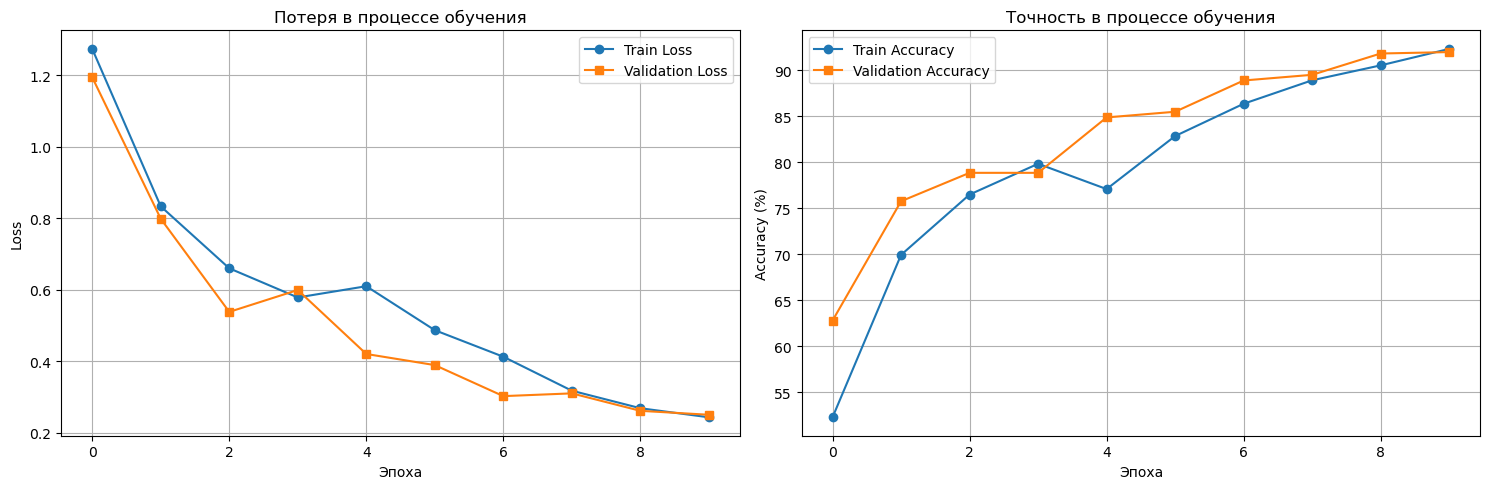

In [11]:
# Визуализация процесса обучения
if 'train_losses' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Validation Loss', marker='s')
    ax1.set_title('Потеря в процессе обучения')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(val_accs, label='Validation Accuracy', marker='s')
    ax2.set_title('Точность в процессе обучения')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Сначала обучите модель!")


In [12]:
class FlowerSearchSystem:
    """Система поиска похожих изображений цветов"""
    
    def __init__(self, model_path, device='cpu'):
        """
        Инициализация системы поиска
        
        Args:
            model_path (str): Путь к сохраненной модели
            device (str): Устройство для вычислений
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_to_idx = None
        self.idx_to_label = None
        self.image_database = []
        self.features_database = None
        
        # Загружаем модель
        self.load_model(model_path)
        
        # Трансформация для новых изображений
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def load_model(self, model_path):
        """Загрузка обученной модели"""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Модель не найдена: {model_path}")
        
        checkpoint = torch.load(model_path, map_location=self.device)
        self.label_to_idx = checkpoint['label_to_idx']
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
        # Создаем модель с правильной архитектурой
        self.model = FlowerFeatureExtractor(
            backbone='resnet50',
            num_classes=len(self.label_to_idx),
            feature_dim=512
        ).to(self.device)
        
        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"Модель загружена с точностью {checkpoint['val_acc']:.2f}%")
        print(f"Классы: {list(self.label_to_idx.keys())}")
    
    def build_database(self, image_paths, batch_size=32, save_path='flower_features_db.pkl'):
        """
        Построение базы данных признаков для поиска
        
        Args:
            image_paths (list): Список путей к изображениям
            batch_size (int): Размер батча для обработки
            save_path (str): Путь для сохранения базы данных
        """
        # Проверяем, существует ли уже база данных
        if os.path.exists(save_path):
            print("Загружаем существующую базу данных признаков...")
            with open(save_path, 'rb') as f:
                data = pickle.load(f)
                self.image_database = data['image_paths']
                self.features_database = data['features']
            print(f"Загружено {len(self.image_database)} изображений из базы данных")
            return
        
        self.image_database = image_paths
        features_list = []
        
        print(f"Обработка {len(image_paths)} изображений...")
        
        # Обработка батчами
        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            
            # Загружаем и подготавливаем изображения
            for img_path in batch_paths:
                try:
                    image = Image.open(img_path).convert('RGB')
                    image_tensor = self.transform(image)
                    batch_images.append(image_tensor)
                except Exception as e:
                    print(f"Ошибка обработки {img_path}: {e}")
                    # Создаем черное изображение
                    black_image = torch.zeros(3, 224, 224)
                    batch_images.append(black_image)
            
            if batch_images:
                batch_tensor = torch.stack(batch_images).to(self.device)
                
                # Извлекаем признаки
                with torch.no_grad():
                    batch_features = self.model.extract_features(batch_tensor)
                    features_list.append(batch_features.cpu().numpy())
        
        # Объединяем все признаки
        self.features_database = np.vstack(features_list)
        
        # Сохраняем базу данных
        with open(save_path, 'wb') as f:
            pickle.dump({
                'image_paths': self.image_database,
                'features': self.features_database
            }, f)
        
        print(f"База данных признаков создана для {len(self.image_database)} изображений")
    
    def search_similar_flowers(self, query_image_path, top_k=5):
        """
        Поиск похожих изображений цветов
        
        Args:
            query_image_path (str): Путь к изображению запроса
            top_k (int): Количество похожих изображений для возврата
            
        Returns:
            dict: Словарь {image_path: similarity_score} отсортированный по убыванию сходства
        """
        if self.features_database is None:
            raise ValueError("База данных признаков не создана! Выполните build_database()")
        
        # Обрабатываем изображение запроса
        try:
            query_image = Image.open(query_image_path).convert('RGB')
            query_tensor = self.transform(query_image).unsqueeze(0).to(self.device)
        except Exception as e:
            raise ValueError(f"Ошибка обработки изображения запроса: {e}")
        
        # Извлекаем признаки запроса
        with torch.no_grad():
            query_features = self.model.extract_features(query_tensor).cpu().numpy()
        
        # Вычисляем косинусное сходство
        similarities = cosine_similarity(query_features, self.features_database)[0]
        
        # Получаем топ-k наиболее похожих
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # Формируем результат
        results = {}
        for idx in top_indices:
            image_path = self.image_database[idx]
            similarity_score = float(similarities[idx])
            results[image_path] = similarity_score
        
        return results
    
    def display_search_results(self, query_image_path, results):
        """Визуализация результатов поиска"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Показываем изображение запроса
        query_img = Image.open(query_image_path)
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title("Изображение запроса", fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Показываем найденные похожие изображения
        for i, (image_path, similarity) in enumerate(results.items()):
            if i >= 5:  # Показываем только топ-5
                break
                
            row = (i + 1) // 3
            col = (i + 1) % 3
            
            try:
                img = Image.open(image_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(
                    f"Ранг {i+1}\\nСходство: {similarity:.3f}\\n{Path(image_path).name}", 
                    fontsize=10
                )
                axes[row, col].axis('off')
            except Exception as e:
                axes[row, col].text(0.5, 0.5, f"Ошибка\\n{Path(image_path).name}", 
                                   ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

print("Класс FlowerSearchSystem определен!")


Класс FlowerSearchSystem определен!


In [19]:
# Создание системы поиска (только если модель обучена)
if os.path.exists('best_flower_model.pth'):
    # Инициализируем систему поиска
    search_system = FlowerSearchSystem('best_flower_model.pth', device=device)
    
    # Используем все изображения из тестового набора для базы данных
    if 'test_df' in locals():
        all_image_paths = df['image_path'].tolist()  # Используем весь датасет
        search_system.build_database(all_image_paths, batch_size=64)
        
        print("Система поиска готова к использованию!")
    else:
        print("Тестовый датасет не найден")
else:
    print("Обученная модель не найдена. Сначала обучите модель!")


Модель загружена с точностью 91.98%
Классы: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Загружаем существующую базу данных признаков...
Загружено 4317 изображений из базы данных
Система поиска готова к использованию!


🔍 Поиск похожих изображений для: 7471890996_e61b134867_n.jpg
📝 Истинный класс: rose
------------------------------------------------------------
Результаты поиска (топ-5 похожих изображений):
1. matc 7471890996_e61b134867_n.jpg
   Путь: flowers-recognition/flowers/rose/7471890996_e61b134867_n.jpg
   Показатель сходства: 1.000000
   Класс: rose

2. matc 8279801891_5369a6c3c1_n.jpg
   Путь: flowers-recognition/flowers/rose/8279801891_5369a6c3c1_n.jpg
   Показатель сходства: 0.993000
   Класс: rose

3. matc 14127110749_624f5bfde6_n.jpg
   Путь: flowers-recognition/flowers/rose/14127110749_624f5bfde6_n.jpg
   Показатель сходства: 0.992919
   Класс: rose

4. matc 2414954629_3708a1a04d.jpg
   Путь: flowers-recognition/flowers/rose/2414954629_3708a1a04d.jpg
   Показатель сходства: 0.991574
   Класс: rose

5. matc 3903276582_fe05bf84c7_n.jpg
   Путь: flowers-recognition/flowers/rose/3903276582_fe05bf84c7_n.jpg
   Показатель сходства: 0.990967
   Класс: rose

Визуализация результатов:


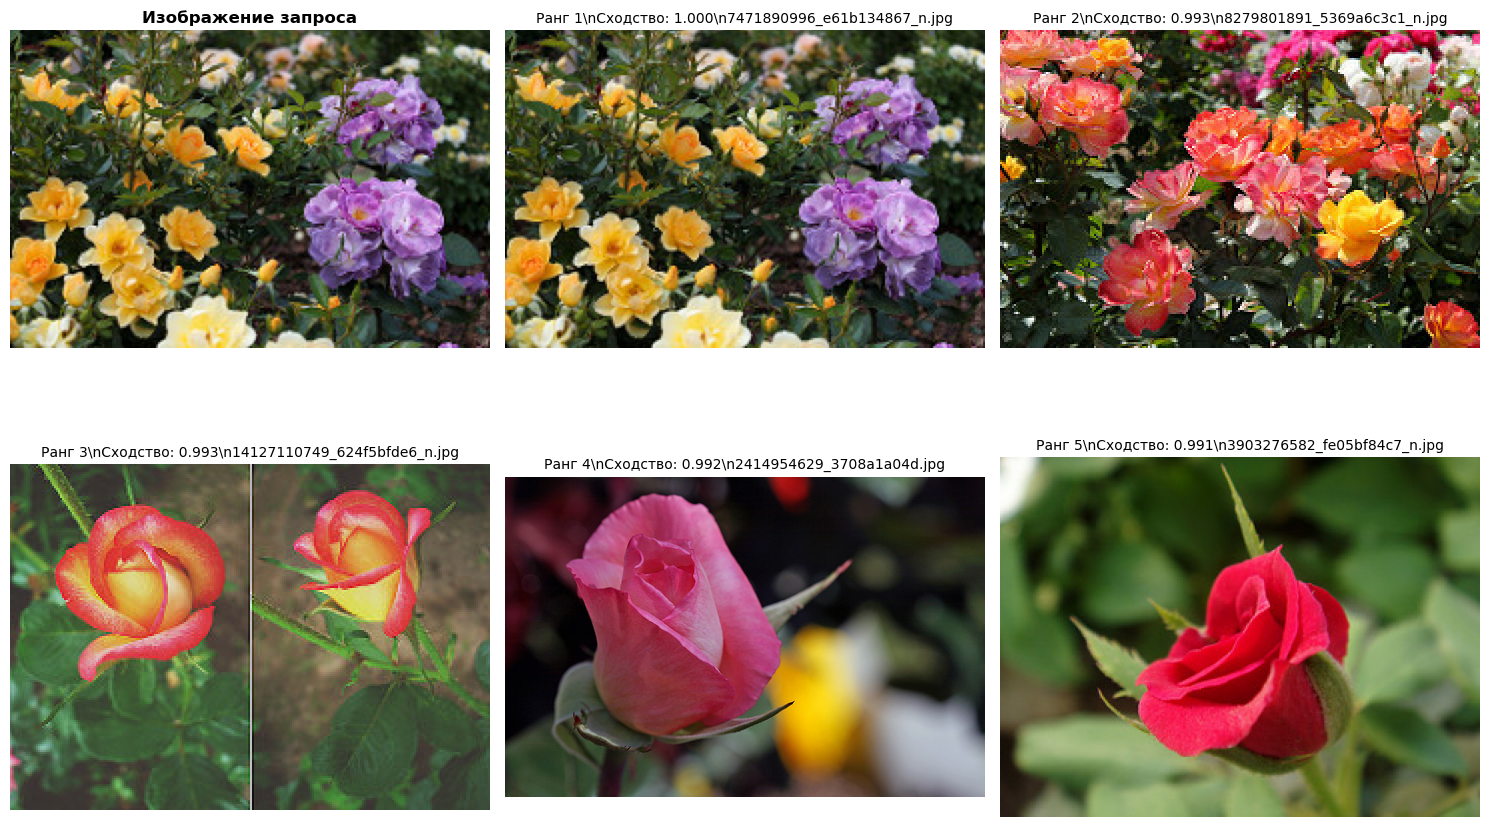

In [21]:
# Демонстрация поиска похожих изображений
if 'search_system' in locals() and 'test_df' in locals():
    # Выбираем случайное изображение из тестового набора для демонстрации
    query_image_path = random.choice(test_df['image_path'].tolist())
    query_label = test_df[test_df['image_path'] == query_image_path]['label'].iloc[0]
    
    print(f"🔍 Поиск похожих изображений для: {Path(query_image_path).name}")
    print(f"📝 Истинный класс: {query_label}")
    print("-" * 60)
    
    # Выполняем поиск топ-5 похожих изображений
    results = search_system.search_similar_flowers(query_image_path, top_k=5)
    
    # Выводим результаты в требуемом формате
    print("Результаты поиска (топ-5 похожих изображений):")
    print("=" * 80)
    
    for rank, (image_path, similarity_score) in enumerate(results.items(), 1):
        # Определяем класс найденного изображения
        found_label = df[df['image_path'] == image_path]['label'].iloc[0] if image_path in df['image_path'].values else "unknown"
        match_indicator = "matc" if found_label == query_label else "not match"
        
        print(f"{rank}. {match_indicator} {Path(image_path).name}")
        print(f"   Путь: {image_path}")
        print(f"   Показатель сходства: {similarity_score:.6f}")
        print(f"   Класс: {found_label}")
        print()
    
    # Визуализация результатов
    print("Визуализация результатов:")
    search_system.display_search_results(query_image_path, results)
    
else:
    print("Система поиска не инициализирована или данные не загружены")


In [23]:
# Функция для поиска по пользовательскому изображению
def search_custom_image(image_path, search_system, top_k=5):
    """
    Поиск похожих изображений для пользовательского файла
    
    Args:
        image_path (str): Путь к изображению пользователя
        search_system: Инициализированная система поиска
        top_k (int): Количество похожих изображений
        
    Returns:
        dict: Словарь {image_path: similarity_score} отсортированный по убыванию
    """
    try:
        results = search_system.search_similar_flowers(image_path, top_k=top_k)
        
        print(f"Результаты поиска для изображения: {Path(image_path).name}")
        print("=" * 80)
        
        for rank, (img_path, score) in enumerate(results.items(), 1):
            print(f"{rank}. Путь: {img_path}")
            print(f"   Сходство: {score:.6f}")
            print()
        
        return results
        
    except Exception as e:
        print(f"Ошибка поиска: {e}")
        return {}

# Пример использования функции
print("Для поиска по своему изображению используйте функцию:")
print("results = search_custom_image('path/to/your/image.jpg', search_system)")
print("search_system.display_search_results('path/to/your/image.jpg', results)")


Для поиска по своему изображению используйте функцию:
results = search_custom_image('path/to/your/image.jpg', search_system)
search_system.display_search_results('path/to/your/image.jpg', results)


In [24]:
def evaluate_search_quality(search_system, test_samples, k_values=[1, 3, 5]):
    """
    Оценка качества поиска с помощью метрик Precision@K и Recall@K
    
    Args:
        search_system: Система поиска
        test_samples: Список (image_path, true_label) для тестирования
        k_values: Значения K для оценки
    """
    results = {f"precision@{k}": [] for k in k_values}
    results.update({f"recall@{k}": [] for k in k_values})
    
    print("Оценка качества поиска...")
    
    for query_path, true_label in tqdm(test_samples[:50]):  # Тестируем на 50 изображениях
        try:
            # Поиск похожих изображений
            search_results = search_system.search_similar_flowers(query_path, top_k=max(k_values))
            
            # Определяем истинные метки найденных изображений
            found_labels = []
            for img_path in search_results.keys():
                if img_path in df['image_path'].values:
                    label = df[df['image_path'] == img_path]['label'].iloc[0]
                    found_labels.append(label)
                else:
                    found_labels.append("unknown")
            
            # Вычисляем метрики для разных значений K
            for k in k_values:
                top_k_labels = found_labels[:k]
                relevant_found = sum(1 for label in top_k_labels if label == true_label)
                
                # Precision@K
                precision_k = relevant_found / k if k > 0 else 0
                results[f"precision@{k}"].append(precision_k)
                
                # Recall@K (для нашего случая - относительно всех доступных релевантных)
                total_relevant = len(df[df['label'] == true_label])
                recall_k = relevant_found / min(total_relevant, k) if total_relevant > 0 else 0
                results[f"recall@{k}"].append(recall_k)
                
        except Exception as e:
            print(f"Ошибка при обработке {query_path}: {e}")
            continue
    
    # Вычисляем средние значения
    print("Результаты оценки качества поиска:")
    print("=" * 50)
    
    for metric, values in results.items():
        if values:
            avg_value = np.mean(values)
            std_value = np.std(values)
            print(f"{metric.upper()}: {avg_value:.4f} ± {std_value:.4f}")
    
    return results

# Проводим оценку если система готова
if 'search_system' in locals() and 'test_df' in locals():
    # Подготавливаем тестовые образцы
    test_samples = list(zip(test_df['image_path'].tolist(), test_df['label'].tolist()))
    
    # Оценка качества
    quality_results = evaluate_search_quality(search_system, test_samples, k_values=[1, 3, 5])
else:
    print("Система поиска или тестовые данные не готовы")


Оценка качества поиска...


100%|██████████| 50/50 [00:04<00:00, 11.06it/s]

Результаты оценки качества поиска:
PRECISION@1: 1.0000 ± 0.0000
PRECISION@3: 0.9267 ± 0.2032
PRECISION@5: 0.9160 ± 0.2301
RECALL@1: 1.0000 ± 0.0000
RECALL@3: 0.9267 ± 0.2032
RECALL@5: 0.9160 ± 0.2301
